# Notes on Learning representations by back-propagating errors (1986)
## Authors: David E. Rumelhart, Geoffrey E. Hinton, Ronald J. Williams
### Notes: Michael Holtz

### Abstract

They describe a novel learning approach to the weights of neural networks (referred to as neurone-like units). The procedure iteratively adjusts the weights of the connections in the network to minimize a measure between the output vector and a goal vector. They claim that these weight adjustments allow internal units (hidden layers) to represent important features of the "task domain". Furthermore "regularities in the task are captured by the interactions of these units". 

### The Goal

The goal is a general learning algorithm for units that are not directly connected to either the input or the output. Perceptrons had a similar structure, however the weights of internal connections was entirely written by hand, so there was no learning on internal layers. This algorithm boils down to determining when internal neurons should activate in order to map input vectors to their correct output vectors. 


### The Network
They then describe the simplest form of their procedure, which occurs on a network following these rules:  
1) The network begins with an input layer
2) The network end with an output layer
3) The network contains 0 or more intermediate layers between the input layer and the output layer
4) Connections between neurons must only be formed between neurons in different layers
5) The input of each neuron is determined by $x_j = \sum_i y_y w_{ji} + b$ where $x_i$ is the output of a neuron before $x$ with a connection to $x$, $w_ji$ is a learnable weight, and $b$ is a learnable bias.  
6) The output of each neuron is determined by $y_j = \frac{1}{1 + e^{-x_j}}$

They then state that the exact functions in 5 and 6 can be edited, so long as the pair have a bounded derivative. They also state that a linear combination of inputs followed by a non-linear output greatly simplifies the learning procedure. A statement which holds true to today. 

### The error metric

They define the goal of their algorithm is to minimize the following error function over a finite set of input-output cases. $$ E = \frac{1}{2} \sum_c \sum_y (y_{j, c} - d_{j, c})^2$$  
Were E is the total error, c is an index over the training set, y is the predicted output, and d is the desired output. 

### The Algorithm  

The goal is to minimize E via gradient descent. To do so, they compute the partial derivative of E w.r.t. each of the learnable parameters of the network, with is equivalent to the sum of the partial derivatives for each of the input-output cases. Each derivative is computed in two steps. The forward pass is determined via the input-output rules specified above. The backward pass propagates derivatives from the output layer back to the input layer. 

#### The backward pass
We will compute the partial derivative for a single input-output pair. 
1) Compute the partial derivative w.r.t. each of the neurons of the output layer 
   $$\frac{\partial E}{\partial y_j} \frac{1}{2} (y_j - d_j)^2 = (y_j - d_j)$$
2) Apply the chain rule to compute the derivative w.r.t $x_j$, the input to $y_j$  
    $$\frac{\partial E}{\partial x_j} = \frac{\partial E}{\partial y_j} \cdot \frac{\partial y_j}{\partial x_j} $$  
    We can obtain $\frac{\partial y_j}{\partial x_j}$ by taking the partial derivative of the output equation w.r.t. $x_j$
    $$\frac{\partial y_j}{\partial x_j} = y_j(1 - y_j)$$  
3) This gives us the error with respect to the total input of the neuron, but the input is itself a linear function, so we can once again use the chain rule to get the derivative w.r.t. $w_{ji}$, which we can then adjust. 
    $$\frac{\partial E}{\partial w_{ji}} = \frac{\partial E}{\partial x_j} \cdot \frac{\partial x_j}{\partial w_{ji}} $$ 
    $$\frac{\partial x_j}{\partial w_{ji}} = y_i$$  
    Where $y_i$ is the output of a neuron a previous layer
4) To get the partial w.r.t. the next layer, you use the following $$ \frac{\partial E}{\partial y_i} = \sum_j \frac{\partial E}{\partial x_j} w_{ji}$$
5) Repeating these steps allows you to step back one layer at a time until you reach the first weights in the network


### Updating the weights
Once the partial derivatives with respect to each weight are generated, you can update that weight $w$ such that $\Delta w = \epsilon \frac{\partial E}{\partial w}$. Two strategies are noted in the paper. Updating after each input-output pair, and updating after all input-output pairs. Also noted is a modification where the gradient changes the velocity of the weight rather than the position in weight space. 
$$  \Delta w = \epsilon \frac{\partial E}{\partial w(t)} + \alpha \frac{\partial E}{\partial w(t -1)}$$ 
t in this case increments each time all input-output pairs are iterated through, and $\alpha$ is an exponential decay factor, changing how much earlier gradients affect the current one. 

### Conclusion 
 They conclude with a couple of examples (see code), establishing that random weights should be used to initialize the network and pointing out a weakness in this approach. Gradient descent is prone to being caught in local minima, missing out on performance that would be achieved via the global minima. 

### Example problem  
A vector of length 6 is classified as either being symmetric or asymmetric. The example given is a fully connected, feed forward network with 6 input neurons, 2 hidden neurons in one layer, and one output neuron. Neurons 1 - 6 are connected to neurons 7 and 8, which inturn connect to neuron 9, the output. 

In [1]:
import numpy as np

from tqdm import tqdm

np.random.seed(0)

In [2]:
#define input and output functions 
def input(y_prev, ws, b):
    """Input function for a neuron

    Args:
        y_prev (np.array): array of outputs from previous layer
        ws (np.array): array of weights 
        b (float): bias

    Returns:
        float: total input
    """
    return y_prev @ ws + b
def output(x):
    """Non-linear output function of a neuron

    Args:
        x (float): input value

    Returns:
        float: output value
    """
    return 1/(1 + np.e**-x)

In [3]:
class NN: 
    def __init__(self):
        """Initialize weights and biases based on paper's instructions
        """
        self.weights = np.random.uniform(-.3, .3, 14)
        self.biases = np.random.uniform(-.3, .3, 3)
        self.last_delta_grads = np.zeros(14), np.zeros(3)

    
    def update_weights(self, weight_grad, bias_grad, e = .1, a= .9):
        """Update weights and biases based on batch gradient sums and eq. 9 from the paper

        Args:
            weight_grad (np.array): gradient batch sum for weights
            bias_grad (np.array): gradient batch sum for biases
            e (float, optional): gradient multiplier (learning rate). Defaults to .1.
            a (float, optional): exponential decay factor. Defaults to .9.
        """
        weight_del = e * weight_grad + a * self.last_delta_grads[0]
        self.weights -= weight_del
        bias_del = e * bias_grad + a * self.last_delta_grads[1]
        self.biases -= bias_del
        self.last_delta_grads = weight_del, bias_del

    def forward(self, in_vec): 
        """Forward pass of the neural network

        Args:
            in_vec (np.array): binary vector of length 6

        Returns:
            tuple: output values for neurons 6, 7, and 8. 8 is the final output of the network
        """
        x_6 = input(in_vec, self.weights[:6], self.biases[0])
        x_7 = input(in_vec, self.weights[6:12], self.biases[1])
        y_6 = output(x_6)
        y_7 = output(x_7)
        x_8 = input(np.array((y_6, y_7)), self.weights[12:], self.biases[2])
        y_8 = output(x_8)
        return y_6, y_7, y_8
     
    def backward(self, in_vec, y_6, y_7, y_8, y_true):
        """Backpropagation for the neural net. 

        Args:
            in_vec (np.array): Output of neurons 0-5
            y_6 (float): Output of neuron 6
            y_7 (float): Output of neuron 7
            y_8 (float): Output of neuron 8
            y_true (float): Ground truth value for input vector

        Returns:
            tuple: partial derivative w.r.t. each weight and each bias
        """
        weight_partials = np.zeros(14)
        bias_partials = np.zeros(3)

        # Partials for neuron 8
        partial_y_8 = y_8 - y_true
        partial_x_8 = partial_y_8 * y_8 * (1 - y_8)

        # partials for second layer of weights and biases
        weight_partials[13] = partial_x_8 * y_7
        weight_partials[12] = partial_x_8 * y_6
        bias_partials[2] = partial_x_8

        # Partials for neurons 6 and 7
        partial_y_7 = partial_x_8 * self.weights[13]
        partial_x_7 = partial_y_7 * y_7 * (1 - y_7)
        partial_y_6 = partial_x_8 * self.weights[12]
        partial_x_6 = partial_y_6 * (y_6) * (1 - y_6)

        # Partials for first layer of weights and biases
        weight_partials[6:12] = partial_x_7 * in_vec
        bias_partials[1] = partial_x_7
        weight_partials[:6] = partial_x_6 * in_vec
        bias_partials[0] = partial_x_6

        return weight_partials, bias_partials

In [4]:
import itertools

# Generate dataset
X = np.array(list(itertools.product([0, 1], repeat=6)))
y = np.zeros((64, 1))

for i, (in_vec) in enumerate(X):
    if (in_vec[:3] == in_vec[::-1][:3]).all():
        y[i] = 1

np.sum(y)

np.float64(8.0)

In [5]:
# Create an instance of our network
net = NN()

In [6]:
# Define the training loop
# The paper states 1425 sweeps (epochs) needed to achieve a perfect score

loss, accuracy = [], []
for epoch in tqdm(range(1000)):
    # Track cumulative error, correct guesses, weight gradient sum, batch gradient sum
    epoch_error = 0
    epoch_correct = 0
    batch_weight = np.zeros(14)
    batch_bias = np.zeros(3)

    # Loop over 64 vectors in training set
    for i, in_vec in enumerate(X):
        y_6, y_7, y_8 = net.forward(in_vec)
        
        epoch_error += (y_8 - y[i]) ** 2
        epoch_correct += float(abs(y_8 - y[i]) < .2)
        
        weight_p, bias_p = net.backward(in_vec, y_6, y_7, y_8, y[i])
        
        batch_weight += weight_p
        batch_bias += bias_p

    # Update weights and biases
    net.update_weights(batch_weight, batch_bias)
    # Track training metrics
    loss.append(epoch_error/64)
    accuracy.append(epoch_correct/64)
    
    if accuracy[-1] == 1:
        break

  0%|          | 0/1000 [00:00<?, ?it/s]C:\Users\Micha\AppData\Local\Temp\ipykernel_28744\340863302.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  epoch_correct += float(abs(y_8 - y[i]) < .2)
C:\Users\Micha\AppData\Local\Temp\ipykernel_28744\2741535366.py:63: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  weight_partials[13] = partial_x_8 * y_7
C:\Users\Micha\AppData\Local\Temp\ipykernel_28744\2741535366.py:64: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  wei

### Training breakdown

The network took 846 sweeps to learn whether a length 6 vector was mirrored. I set the threshold for correct classification at .2. Another option would be to consider all predictions < .5 as 0 and >= .5 as 1. This would likely result in a shorter training time. Looking at the loss and accuracy below, the shape of each curve is contrary to what I have seen in the past. The accuracy dips late in training, before bouncing around and reaching 1. The loss looks more familiar, however it seems to bounce a bit before leveling off. This could be because of the exponential decay term in the optimizer. 

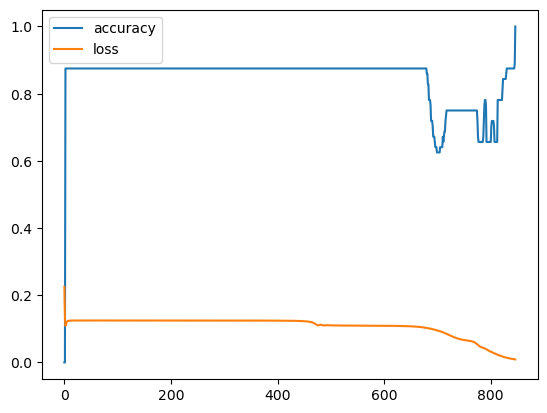

In [7]:
import matplotlib.pyplot as plt

plt.plot(accuracy, label = 'accuracy')
plt.plot(loss, label = 'loss')
plt.legend()

In [8]:
net.weights[:6], net.weights[6:12], net.weights[12:], net.biases

(array([-2.13520609,  4.23356045, -8.39599728,  8.3946728 , -4.2355389 ,
         2.13277956]),
 array([ 2.1556448 , -4.27959344,  8.48300179, -8.48416879,  4.27795855,
        -2.15733541]),
 array([-10.34858855, -10.31945361]),
 array([-1.78081604, -1.79780053,  4.36729403]))